In [1]:
import logging
import warnings
import sys
import pandas as pd
import numpy as np

sys.path.append('../')  # to include the SR code without installing in the environment

from symbolic_regression.SymbolicRegressor import SymbolicRegressor

# The operations

Here we define the list of allowed operations. In this project we implemented most of the arithmetic operations we expect to need in a normal use. Please have a look at the file in `symbolic_regression/operators.py` to see how we define them and to define your own operators.

In [2]:
from symbolic_regression.operators import *

operations = [
    OPERATOR_ADD,
    OPERATOR_SUB,
    OPERATOR_MUL,
    OPERATOR_DIV,
    # OPERATOR_ABS,
    # OPERATOR_MOD,
    # OPERATOR_NEG,
    # OPERATOR_INV,
    OPERATOR_LOG,
    OPERATOR_EXP,
    OPERATOR_POW,
    OPERATOR_SQRT,
    OPERATOR_MAX,
    OPERATOR_MIN
]

# The example dataset: counterfeit banknotes classification

This is a very simple binary classification task to predict whether a banknote is counterfeit based on four characteristics. This dataset is publicly available at [Kaggle](https://kaggle.com)

In [3]:
data = pd.read_csv('./banknotes.csv')

data = data.sample(frac=1)

data['w'] = np.where(data['y']==1, 1./(2*data['y'].mean()),  1./(2*(1-data['y'].mean())))

features = ['x_1', 'x_2', 'x_3', 'x_4']
target = 'y'
weights = 'w'

print(f'Dataset {data.shape}')

Dataset (1372, 6)


Here we define the base range for which to generate the constants in the individuals. Furthermore, we also define how to optimize those constants in order to make them converge to the best value they can have in their expression.

We are using ADAM with the following configuration parameters.

In [4]:
const_range = (0, 1)

constants_optimization = True
constants_optimization_method= 'ADAM'
constants_optimization_conf = {
    'task':'binary:logistic', #or 'regression:wmse'
    'learning_rate': 1e-4,
    'batch_size': 64,
    'epochs': 50,
    'verbose': 0,
    'gradient_clip':False,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'epsilon': 1e-7    
}

In [5]:
''' This implements the error functions to be minimized.
The arguments of this function must not change as the code expects them to be
as appear here.

Use a dict with this structure:
    {
        <name_of_the_error_function>: {
            'func': the actual function to be evaluated,
            'threshold': the value below which convergence happens # Optional
        }
    }
'''


def multi_obj(program, data):
    from symbolic_regression.multiobjective.functions import (
        not_constant, ordering_preserving, accuracy_bce, wrrmse, auroc_bce,
        ordering, value_range, wmse, complexity, binary_cross_entropy)

    ''' Some examples are
    
    'not_constant': {
            'func': not_constant(program=program, data=data, epsilon=.01)
        }
    'wmse': {
            'func': wmse(program=program, data=data, target=target, weights=weights),
            'convergence_threshold': 1
        },
    'bce': {
            'func': binary_cross_entropy(
                program=program, data=data, target='y', logistic=True,
                constants_optimization=constants_optimization,
                constants_optimization_method=constants_optimization_method,
                constants_optimization_conf=constants_optimization_conf
                )
        },
    'order_preserving_error_1': {
        'func': ordering(program=program, data=data, target='y_1', method='error')
    },
    'order_preserving_error_2': {
        'func': ordering(program=program, data=data, target='y_2', method='error')
    },
    'gmeans': {
        'func': gmeans(program=program, data=data, target='y', logistic=True),
        'minimize': True
    },
    'AUC': {
        'func': auroc_bce(program=program, data=data, target='y', logistic=True),
        'minimize': True
    },
    '''
    return {
        'bce': {
            'func': binary_cross_entropy(
                program=program, data=data, target=target, weights=weights, logistic=True,
                constants_optimization=constants_optimization,
                constants_optimization_method=constants_optimization_method,
                constants_optimization_conf=constants_optimization_conf
            )
        },
        '1-AUC': {
            'func': auroc_bce(program=program, data=data, target='y', logistic=True, one_minus= True),
            'minimize': True
        },
        'not_constant': {
            'func': not_constant(program=program, data=data, epsilon=.01),
            'minimize': True
        }
    }


''' Use this to modulate the relative frequency of genetic operations
    E.g., crossover is chosen 2 times more frequently than mutation
        {
            'crossover': 2,
            'mutation': 1
        }
'''
genetic_operators_frequency = {
    'crossover': 1,
    'randomize': 1,
    'mutation': 1,
    'insert_node': 1,
    'delete_node': 1,
    'mutate_leaf': 1,
    'mutate_operator': 1,
    'recalibrate': 1
}

Here we define a population size of 100 individuals, the training process to be 20 generations long and the tournament size for the genetic operations to be 3.

Setting the checkpoint file allows us to progressively save the population to recover the training in future training sessions or to share the population with other participants.

In [6]:
POPULATION_SIZE = 100
GENERATIONS = 20
TOURNAMENT_SIZE = 3

logging.info(f'Running with POPULATION_SIZE {POPULATION_SIZE}')
logging.info(f'Running with GENERATIONS {GENERATIONS}')
logging.info(f'Running with TOURNAMENT_SIZE {TOURNAMENT_SIZE}')


sr = SymbolicRegressor(
    checkpoint_file='./banknotes_checkpoint.save',
    checkpoint_frequency=10,
    const_range=const_range,
    parsimony=.8,
    parsimony_decay=.85,  # Expected depth = parsimony / (1-parsimony_decay)
    population_size=POPULATION_SIZE,
    tournament_size=TOURNAMENT_SIZE
)

In [7]:
sr.fit(
    data=data,
    features=features,
    fitness_functions=multi_obj,
    generations=GENERATIONS,
    genetic_operators_frequency=genetic_operators_frequency,
    operations=operations,
    n_jobs=-1,
    stop_at_convergence=False,
    verbose=1
)

print('End')

/home/davide/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


############################################################
Generation 1/20 - 0 sec
(c0 + ((c1 / log(x_1)) * (c2 * x_3)))

(c0 * (x_4 ** c1))

(c0 + (c1 * x_2))

(c0 + (c1 * log(log((c2 + (c3 * x_3))))))

(c0 + (c1 * log(log((c2 + (c3 * x_3))))))

((c0 * ((c1 / x_1) ** c2)) + (c3 + (c4 * (c5 / x_1))))
(c0 + (c1 * sqrt(x_3)))
(c0 * (x_1 ** c1))


(c0 * (x_3 ** c1))


((x_4 ** c0) * (c1 * sqrt(x_1)))

(c0 + (c1 * log((c2 + (c3 * x_3)))))

(c0 + ((x_4 ** c1) * (c2 * x_2)))

((c0 * ((c1 / x_1) ** c2)) + (c3 + (c4 * (c5 / x_1))))

(c0 + (((x_1 * (c1 / x_3)) ** c2) * (c3 * x_3)))


Population of 100 elements and average complexity of 5.99

	Best individual(s) in the first Pareto Front
0)	((-0.13262531395722552 * x_1) + ((-0.04356179175242624 * sqrt(x_4)) + (0.2695718957894081 + (-0.054565790022366153 * x_2))))

	{'bce': 0.5237176208010689, '1-AUC': 0.054360827847338866, 'not_constant': 0.0}

############################################################
Generation 2/20 - 9.456762476125732 sec

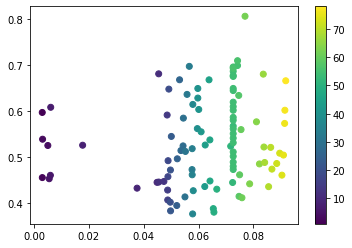

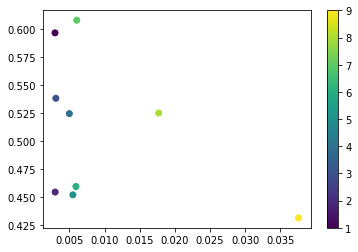

In [8]:
AUC_list=[]
bce_list=[]
rank_list=[]
not_constant_list=[]

for p in sr.population:
    AUC_list.append(p.fitness['1-AUC'])
    bce_list.append(p.fitness['bce'])
    not_constant_list.append(p.fitness['not_constant'])
    rank_list.append(p.rank)
    
import matplotlib.pyplot as plt
plt.scatter(AUC_list, bce_list, c=rank_list, cmap='viridis')
plt.colorbar()
plt.show()

indices=np.where(np.array(rank_list)<10)
import matplotlib.pyplot as plt
plt.scatter(np.array(AUC_list)[indices], np.array(bce_list)[indices], c=np.array(rank_list)[indices], cmap='viridis')
plt.colorbar()
plt.show()